# Historic simulation preserving autocorrelations

Let $X=(X_1,\dots,X_m)$ be a random vector of asset returns, which we'd like to simulate using previous observations $X^{(i)},\;i=1,\dots,n$, and some reasonable assumptions if necessary. Usual approaches to the problem include (a) Monte Carlo method, which requires assuming some parametric form of joint distribution of $X$ components, and estinating parameters from observations, and (b) Historic method, which does not require any distributional assumptions, and takes samples directly from observations at hand.

In [1]:
import os
import pandas as pd
import scipy.stats as ss
from scipy.optimize import brentq
import simulation_historic as sh
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Confidence interval for the mean of independent variables product

Note that if $X, Y$ are independent copies of a random variable with zero mean and variance $EX^2=EY^2=\sigma^2$, then for $Z=XY$ we have $EZ=0$, variance of the product $Z$ equals $E(Z)^2-(EX\cdot EY)^2=EX^2\cdot EY^2=(\sigma^2)^2$, and standard deviation is $\sigma^2$. In particular, 95% confidence interval for the mean estimate

$$
\widehat{\mu} = \frac1{n}\sum_{i=1}^n X_i Y_i
$$
has the form

$$
I = \left(-\frac{\sigma^2 q}{\sqrt{n}}, \frac{\sigma^2 q}{\sqrt{n}}\right),
$$
where $q=N^{-1}(0.975)$ is the 97.5% quantile of the standard normal distribution. This interval may be used for testing the hypothesis of zero correlation.

## Estimating autocorrelation function for time series of returns

Consider indices SnP500, DJIA, NASDAQ, VIX, and stock close returns for Apple, Google, and Microsoft.

In [2]:
# read assets data
df = sh.read_data()

# compute returns
dfr = sh.calc_all_returns(df)

In [3]:
def show_corr(dfr, cl='aapl', depth=5):
    """ """
    se = dfr[cl]
    dft = dfr[[cl]].copy()
    lst = list()
    for i in range(1, depth + 1):
        clsh = '{0}'.format(i)
        lst.append(clsh)
        dft[clsh] = se.shift(-i)
    dft.dropna(inplace=True)
    return dft.corr().loc[cl, lst]

In [4]:
cls = dfr.columns
depth = 5
ind = ['{0}'.format(i) for i in range(1, depth + 1)]
dfo = pd.DataFrame(index=ind)
dfo.index.name = 'lag'
for cl in cls:
    dfo[cl] = show_corr(dfr, cl, depth=depth)
fm = 'autocorrelation functions for lag = 1 .. {0}'
print(fm.format(depth))
print('-------------------------------------------')
print(dfo.round(3))

autocorrelation functions for lag = 1 .. 5
-------------------------------------------
       snp   djia  nasdaq  microsoft  apple  google    vix
lag                                                       
1   -0.102 -0.100  -0.069     -0.060  0.006   0.011 -0.089
2   -0.060 -0.056  -0.045     -0.043 -0.022  -0.006 -0.043
3    0.033  0.050   0.020      0.036 -0.001  -0.011 -0.027
4   -0.027 -0.028  -0.033     -0.058  0.044   0.016 -0.034
5   -0.048 -0.053  -0.030     -0.037  0.012   0.001 -0.031


The table above contains autocorrelations for time lags 1, 2, 3, 4, 5. Below is the graphic representation of the same functions.

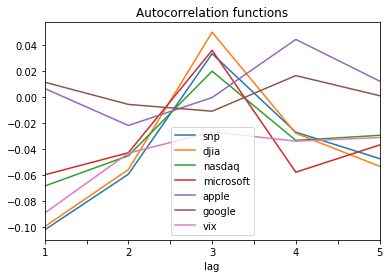

In [5]:
dfo.plot();
title('Autocorrelation functions');

Now let's test the hypothesis of zero autocorrelation for a number of lags and all assets.

In [6]:
def check_mu(dfr, cl='aapl', depth=5, q=ss.norm.ppf(0.975)):
    """ """
    se = dfr[cl]
    sig2 = se.var()
    dft = dfr[[cl]].copy()
    lst = list()
    for i in range(1, depth + 1):
        clsh = '{0}'.format(i)
        lst.append(clsh)
        dft[clsh] = se.shift(-i)
    dft.dropna(inplace=True)
    n_loc = dft.shape[0]
    bnd = q * sig2 / n_loc ** 0.5
    lout = list()
    cls = list()
    for clsh in lst:
        mu_hat = (dft[cl] * dft[clsh]).mean()
        lout.append(sh.hyp_txt[-bnd <= mu_hat <= bnd])
        cls.append(clsh)
    se = pd.Series(lout, index=cls)
    se.name = cl
    return se

def check_all_mus(dfr, depth=5, q = ss.norm.ppf(0.975)):
    """ """
    dfo = None
    for cl in dfr.columns:
        se = check_mu(dfr, cl=cl, depth=depth, q=q)
        se.name = cl
        if dfo is None:
            dfo = pd.DataFrame(se)
        else:
            dfo[cl] = se
    dfo.index.name = 'lag'
    return dfo

In [7]:
q = ss.norm.ppf(0.975)
print(check_all_mus(dfr, depth=5, q=q))

          snp      djia    nasdaq microsoft     apple google       vix
lag                                                                   
1    Rejected  Rejected  Rejected  Rejected         -      -  Rejected
2    Rejected  Rejected  Rejected  Rejected         -      -  Rejected
3           -  Rejected         -  Rejected         -      -         -
4           -         -         -  Rejected  Rejected      -         -
5    Rejected  Rejected         -  Rejected         -      -         -


We see that autocorrelation fails to get into 95% confidence interval for most lags and most assets; only Apple and Google stocks seem to be free of autocorrelation. Thus in what follows we will pay more attention to indices and Microsoft stocks.

## Historic simulation keeping autocorrelations

To keep autocorrelations presented in the data, we will include records into sample not one by one, but by whole bunches of size $z$, that is, given an initial index $i$, we include onto the sample all the points with indices $i, i+1, \dots, i+z-1$.

In what follows we implement three styles of historic simulations:

- A: bunched simulation without bunches overlapping; in this case initial index of any bunch is taken at random from the set $\{1, z+1, 2z+1, \dots\}$;
- B: bunched simulation with bunch overlapping; in this case initial index of any bunch is taken at random from the set $\{1, 2, \dots, n-z+1\}$;
- C: standard historic simulation (bunch size equals 1).

In [8]:
interesting_columns = ['djia', 'nasdaq', 'snp', 'vix', 'microsoft']

In [9]:
def run_simul(bsize=5, plot_it=False, save_it=False):
    """ """
    depth = 5
    
    # simulated autocorrelations
    acr = sh.autocorr_all(dfr, depth=depth)
    dfh = sh.direct_hist_sample(dfr)[interesting_columns]
    ach = sh.autocorr_all(dfh, depth=depth)
    dfb = sh.bunched_hist_sample(dfr, bunchsize=bsize)[interesting_columns]
    acb = sh.autocorr_all(dfb, depth=depth)
    dfo = sh.bunched_overlap_hist_sample(dfr, bunchsize=bsize)[interesting_columns]
    aco = sh.autocorr_all(dfo, depth=depth)
    
    erd = dict()
    for cl in dfh.columns:
        dft = pd.DataFrame(index=range(1, depth + 1))
        dft.index.name = 'lag'
        dft['actual'] = acr.loc[1:, cl].copy()
        dft['simple'] = ach.loc[1:, cl].copy()
        dft['bunch'] = acb.loc[1:, cl].copy()
        dft['bunch_ov'] = aco.loc[1:, cl].copy()
        if plot_it:
            dft.plot(kind='bar')
            ylabel('correlation')
            title(cl)
        
        # errors
        dfe = pd.DataFrame(index=range(1, depth + 1))
        dfe['bunch'] = dft.bunch - dft.actual
        dfe['bunch_ov'] = dft.bunch_ov - dft.actual
        dfe['simple'] = dft.simple - dft.actual
        dfe.columns = sh.fig_columns
        erd[cl] = dfe
        if save_it:
            dfe.to_csv('csv/{0}_{1}.csv'.format(cl, bsize), index=False)
    return erd

### Computing errors

In [10]:
save_it = True
erd_3 = run_simul(bsize=3, save_it=save_it)
erd_5 = run_simul(bsize=5, save_it=save_it)
erd_20 = run_simul(bsize=20, save_it=save_it)

#### Plot error diagrams

In [11]:
def make_errors_df(bsize=3):
    """ """
    end = '{0}.csv'.format(bsize)
    ls = [s for s in os.listdir('csv') if s.endswith(end)]
    dfo = pd.DataFrame()
    for fn in ls:
        dfo = dfo.append(pd.read_csv('csv/' + fn).loc[:1, :])
    dd = dict()
    for ind in dfo.index.unique():
        df = dfo[dfo.index == ind]
        df.index = [s[:-6] for s in ls]
        df.columns = sh.fig_columns
        df.index.name = sh.asset_title
        dd[str(ind)] = df.round(3)
    return dd

In [12]:
dd = make_errors_df()

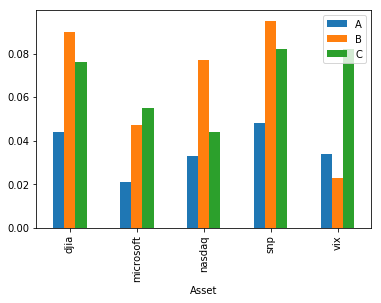

In [13]:
dd['0'].plot.bar();

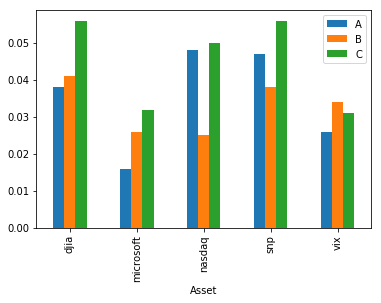

In [14]:
dd['1'].plot.bar();

### Bunch size 5

#### Autocorrelations

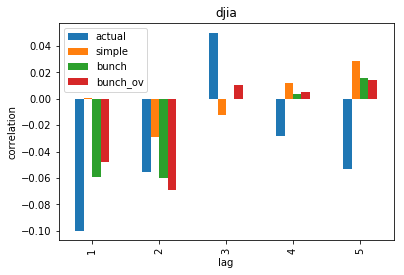

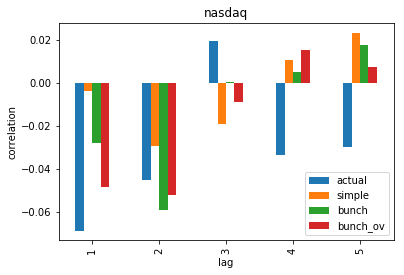

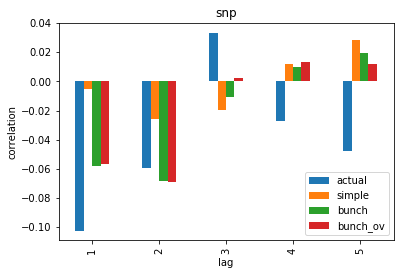

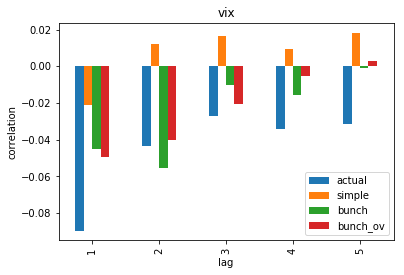

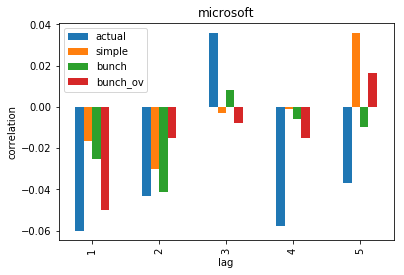

In [15]:
figsize(6, 4)
erd_5 = run_simul(bsize=5, plot_it=True)

#### Errors

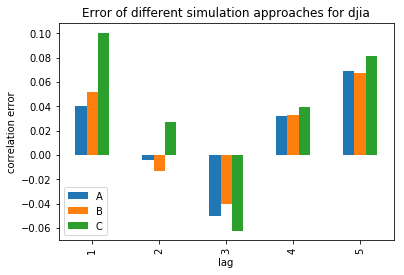

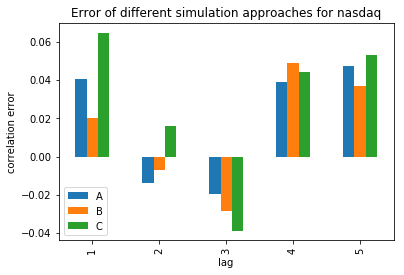

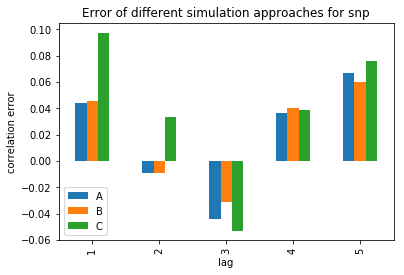

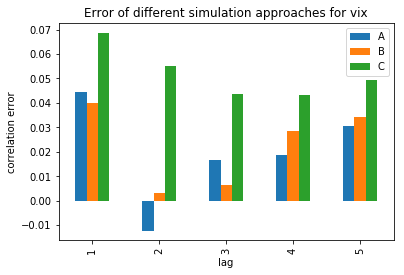

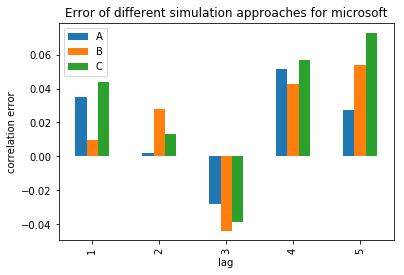

In [16]:
def show_error(erd):
    """ """
    for cl in interesting_columns:
        erd[cl].plot(kind='bar')
        title('Error of different simulation approaches for {0}'.format(cl))
        xlabel('lag')
        ylabel('correlation error');
show_error(erd_5)

### Bunch size 20

#### Autocorrelations

In [17]:
figsize(6, 4)
erd_20 = run_simul(bsize=20)

#### Errors

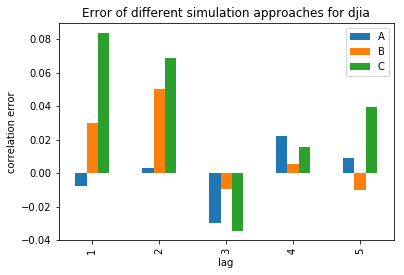

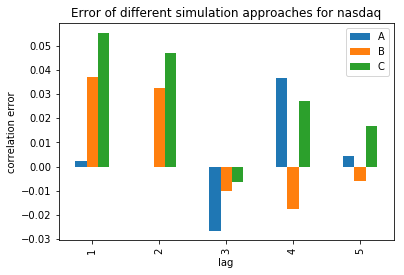

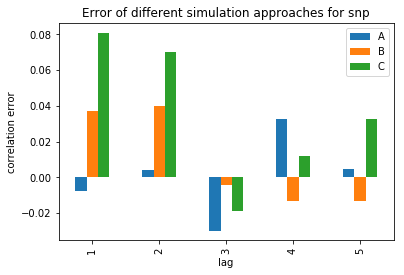

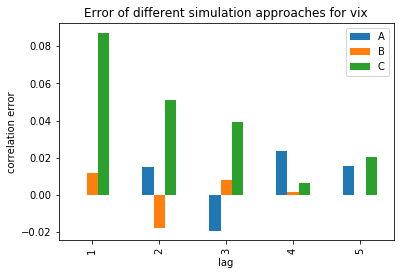

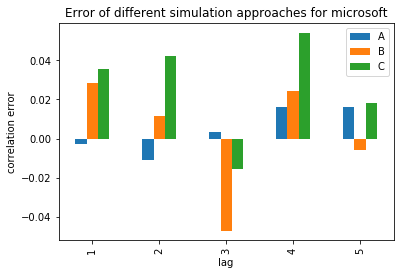

In [18]:
show_error(erd_20)

### Bunch size 50

#### Autocorrelations

In [19]:
figsize(6, 4)
erd_50 = run_simul(bsize=50)

#### Errors

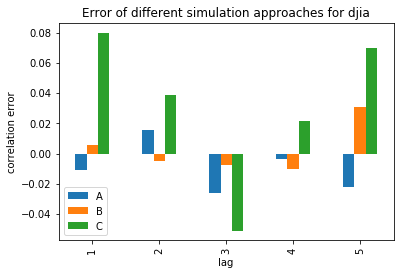

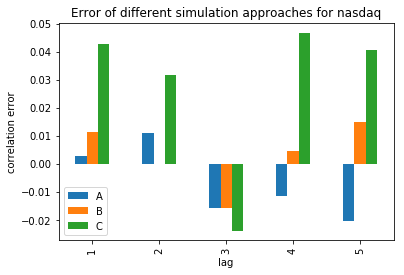

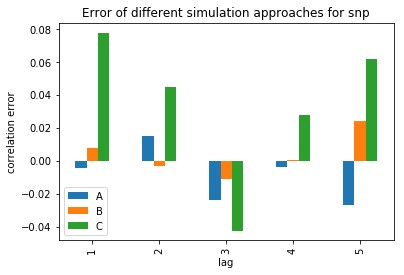

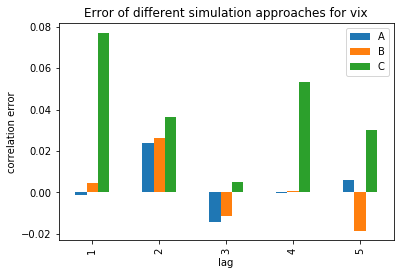

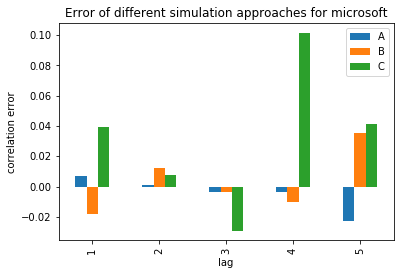

In [20]:
show_error(erd_50)

## Conclusion

We see that simple sampling (C) always produces the poorest quality of autocorrelation reproduction. As for no overalpping (A) / allow overlapping (B), the approaches demonstrate moderate error size with no apparent leader between the two.